In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import config_paths, explore
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
bronze_dir = config_paths["bronze_dir"]

In [4]:
df = pd.read_csv(rf"{bronze_dir}/historical_data.csv")

#### Exploratory Data Analysis

In [5]:
explore(df)

--- Exploratory Data Analysis ---
---------------------------------
Head of DataFrame:
    market_id           created_at actual_delivery_time  store_id  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:27:16      1845   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:56:29      5477   
2        3.0  2015-01-22 20:39:28  2015-01-22 21:09:09      5477   
3        3.0  2015-02-03 21:21:45  2015-02-03 22:13:00      5477   
4        3.0  2015-02-15 02:40:36  2015-02-15 03:20:26      5477   

  store_primary_category  order_protocol  total_items  subtotal  \
0               american             1.0            4      3441   
1                mexican             2.0            1      1900   
2                    NaN             1.0            1      1900   
3                    NaN             1.0            6      6900   
4                    NaN             1.0            3      3900   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   

In [6]:
# Convert 'created_at' to datetime format
df["created_at"] = pd.to_datetime(df["created_at"])
df["actual_delivery_time"] = pd.to_datetime(df["actual_delivery_time"])

# Generate actual deliver time (in seconds) for each order
df["actual_total_delivery_duration"] = (df["actual_delivery_time"] - df["created_at"]).dt.total_seconds()

#### Feature derivations

In [7]:
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0


In [8]:
# Extract time-based features
df["order_hour"] = df["created_at"].dt.hour
df["order_dayofweek"] = df["created_at"].dt.dayofweek  # Monday=0, Sunday=6
df["order_month"] = df["created_at"].dt.month

In [9]:
# Categorize time of day
df["time_of_day"] = pd.cut(
    df["order_hour"], 
    bins=[0, 6, 12, 18, 24], 
    labels=["Late Night", "Morning", "Afternoon", "Evening"],
    right=False
)

# Peak hour indicator (assumed peak hours: 11AM-2PM and 6PM-9PM)
df["is_peak_hour"] = df["order_hour"].isin([11, 12, 13, 18, 19, 20]).astype(int)

# Travel time features
# imput null values for features - estimated_order_place_duration, estimated_store_to_consumer_driving_duration based on median values for the given store_id
df["estimated_order_place_duration"] = df.groupby("store_id")["estimated_order_place_duration"].transform(lambda x: x.fillna(x.median()))
df["estimated_store_to_consumer_driving_duration"] = df.groupby("store_id")["estimated_store_to_consumer_driving_duration"].transform(lambda x: x.fillna(x.median()))
df["estimated_non_prep_duration"] = df["estimated_order_place_duration"] + df["estimated_store_to_consumer_driving_duration"]

# Order complexity features
df["avg_item_price"] = df["subtotal"] / df["total_items"]
df["price_spread"] = df["max_item_price"] - df["min_item_price"]
df["unique_items_ratio"] = df["num_distinct_items"] / df["total_items"]
df["is_complex_order"] = ((df["unique_items_ratio"] > 0.5) & (df["total_items"] > 5)).astype(int)

# Market and store historical trends (proxy for past trends)
df["store_median_delivery_time"] = df.groupby("store_id")["actual_total_delivery_duration"].transform("median")

d:\projects\machine_learning_workspace\deliver_pred\.delivery_pred\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [10]:
# Impute missing values for store_primary_category using mode for given store_id
store_category_modes = df.groupby("store_id")["store_primary_category"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df["non_nan_store_primary_category"] = df["store_primary_category"].fillna(df["store_id"].map(store_category_modes))

In [11]:
# impute missing values for market_id using mode for given store_id
market_modes = df.groupby("store_id")["market_id"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df["non_nan_market_id"] = df["market_id"].fillna(df["store_id"].map(market_modes))

# Market and store historical trends (proxy for past trends)
df["market_median_delivery_time"] = df.groupby("non_nan_market_id")["actual_total_delivery_duration"].transform("median")

In [12]:
# Considering features - total_onshift_dashers, total_busy_dashers and total_outstanding_orders are dependent on market_id, we can impute missing values for these features using median for given market_id
market_median_values = df.groupby("non_nan_market_id")[["total_onshift_dashers", "total_busy_dashers", "total_outstanding_orders"]].transform("median")
df["non_nan_total_onshift_dashers"] = df["total_onshift_dashers"].fillna(market_median_values["total_onshift_dashers"])
df["non_nan_total_busy_dashers"] = df["total_busy_dashers"].fillna(market_median_values["total_busy_dashers"])
df["non_nan_total_outstanding_orders"] = df["total_outstanding_orders"].fillna(market_median_values["total_outstanding_orders"])

In [13]:
# Dasher workload features
# How to feature engineer store_busy_factor for records where onshift_dashers as well as busy_dashers are 0?
df["store_busy_factor"] = np.where(df["non_nan_total_onshift_dashers"] == 0, 0, df["non_nan_total_busy_dashers"] / df["non_nan_total_onshift_dashers"])

# handling 0 onshift dashers to feed meaninful features to the model
df["no_dashers_flag"] = (df["non_nan_total_onshift_dashers"] == 0).astype(int)
df["orders_per_dasher"] = np.where(df["non_nan_total_onshift_dashers"] == 0, 
                                   100, # high value to indicate increased delivery load relative to dasher availability
                                   df["non_nan_total_outstanding_orders"] / df["non_nan_total_onshift_dashers"])

In [14]:
df.head(10)

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,order_hour,order_dayofweek,order_month,time_of_day,is_peak_hour,estimated_non_prep_duration,avg_item_price,price_spread,unique_items_ratio,is_complex_order,store_median_delivery_time,non_nan_store_primary_category,non_nan_market_id,market_median_delivery_time,non_nan_total_onshift_dashers,non_nan_total_busy_dashers,non_nan_total_outstanding_orders,store_busy_factor,no_dashers_flag,orders_per_dasher
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,22,4,2,Evening,0,1307.0,860.250000,682,1.000000,0,3779.0,american,1.0,2814.0,33.0,14.0,21.0,0.424242,0,0.636364
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,21,1,2,Evening,0,1136.0,1900.000000,0,1.000000,0,2390.0,mexican,2.0,2601.0,1.0,2.0,2.0,2.000000,0,2.000000
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,20,3,1,Evening,1,1136.0,1900.000000,0,1.000000,0,2390.0,indian,3.0,2646.0,1.0,0.0,0.0,0.000000,0,0.000000
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,21,1,2,Evening,0,735.0,1150.000000,1200,0.833333,1,2390.0,indian,3.0,2646.0,1.0,1.0,2.0,1.000000,0,2.000000
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,2,6,2,Late Night,0,1096.0,1300.000000,500,1.000000,0,2390.0,indian,3.0,2646.0,6.0,6.0,9.0,1.000000,0,1.500000
5,3.0,2015-01-28 20:30:38,2015-01-28 21:08:58,5477,NaN,1.0,3,5000,3,1500,1900,2.0,2.0,2.0,446,338.0,2300.0,20,2,1,Evening,1,784.0,1666.666667,400,1.000000,0,2390.0,indian,3.0,2646.0,2.0,2.0,2.0,1.000000,0,1.000000
6,3.0,2015-01-31 02:16:36,2015-01-31 02:43:00,5477,NaN,1.0,2,3900,2,1200,2700,10.0,9.0,9.0,446,638.0,1584.0,2,5,1,Late Night,0,1084.0,1950.000000,1500,1.000000,0,2390.0,indian,3.0,2646.0,10.0,9.0,9.0,0.900000,0,0.900000
7,3.0,2015-02-12 03:03:35,2015-02-12 03:36:20,5477,NaN,1.0,4,4850,4,750,1800,7.0,8.0,7.0,446,626.0,1965.0,3,3,2,Late Night,0,1072.0,1212.500000,1050,1.000000,0,2390.0,indian,3.0,2646.0,7.0,8.0,7.0,1.142857,0,1.000000
8,2.0,2015-02-16 00:11:35,2015-02-16 00:38:01,5477,indian,3.0,4,4771,3,820,1604,8.0,6.0,18.0,446,289.0,1586.0,0,0,2,Late Night,0,735.0,1192.750000,784,0.750000,0,2390.0,indian,2.0,2601.0,8.0,6.0,18.0,0.750000,0,2.250000
9,3.0,2015-02-18 01:15:45,2015-02-18 02:08:57,5477,NaN,1.0,2,2100,2,700,1200,2.0,2.0,2.0,446,715.0,3192.0,1,2,2,Late Night,0,1161.0,1050.000000,500,1.000000,0,2390.0,indian,3.0,2646.0,2.0,2.0,2.0,1.000000,0,1.000000


#### One-hot encode categorical features - market_id, non_nan_store_primary_category, order_protocol

In [15]:
# one-hot encode categorical features - non_nan_store_primary_category, non_nan_market_id, order_protocol, time_of_day
df = pd.get_dummies(df, columns=["non_nan_store_primary_category", "non_nan_market_id", "order_protocol", "time_of_day"], drop_first=True, dtype=int, prefix=["store_category", "market_id", "order_protocol", "time_of_day"])

#### Drop records which are still null and which are too few relative to overall data size to impute

In [16]:
# drop record with store_ids = 3258, 4122, 5774 (there's one record that has fair number of features with missing values)
df = df[~df["store_id"].isin([3258, 4122, 5774, 5334])]

# drop records with missing values for actual_delivery_time
df = df[~df["actual_delivery_time"].isna()]

In [17]:
# extract final training dataframe by dropping redundant features
train_df = df.drop(
    columns=[
        "actual_delivery_time", 
        "created_at", 
        "store_id", 
        "store_primary_category",
        "market_id",
        "total_onshift_dashers",
        "total_busy_dashers",
        "total_outstanding_orders",
        ]
)

# convert all features to float type for compatibility with ML models
train_df = train_df.astype(float)

In [18]:
for i in train_df.columns:
    if train_df[i].dtype != "float64":
        raise ValueError(f"Column {i} is not of type float64")

In [19]:
train_df.isna().sum()[lambda x: x > 0]

Series([], dtype: int64)

In [20]:
train_df.head(10)

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,order_hour,order_dayofweek,order_month,is_peak_hour,estimated_non_prep_duration,avg_item_price,price_spread,unique_items_ratio,is_complex_order,store_median_delivery_time,market_median_delivery_time,non_nan_total_onshift_dashers,non_nan_total_busy_dashers,non_nan_total_outstanding_orders,store_busy_factor,no_dashers_flag,orders_per_dasher,store_category_african,store_category_alcohol,store_category_alcohol-plus-food,store_category_american,store_category_argentine,store_category_asian,store_category_barbecue,store_category_belgian,store_category_brazilian,store_category_breakfast,store_category_british,store_category_bubble-tea,store_category_burger,store_category_burmese,store_category_cafe,store_category_cajun,store_category_caribbean,store_category_catering,store_category_cheese,store_category_chinese,store_category_chocolate,store_category_comfort-food,store_category_convenience-store,store_category_dessert,store_category_dim-sum,store_category_ethiopian,store_category_european,store_category_fast,store_category_filipino,store_category_french,store_category_gastropub,store_category_german,store_category_gluten-free,store_category_greek,store_category_hawaiian,store_category_indian,store_category_indonesian,store_category_irish,store_category_italian,store_category_japanese,store_category_korean,store_category_kosher,store_category_latin-american,store_category_lebanese,store_category_malaysian,store_category_mediterranean,store_category_mexican,store_category_middle-eastern,store_category_moroccan,store_category_nepalese,store_category_other,store_category_pakistani,store_category_pasta,store_category_persian,store_category_peruvian,store_category_pizza,store_category_russian,store_category_salad,store_category_sandwich,store_category_seafood,store_category_singaporean,store_category_smoothie,store_category_soup,store_category_southern,store_category_spanish,store_category_steak,store_category_sushi,store_category_tapas,store_category_thai,store_category_turkish,store_category_vegan,store_category_vegetarian,store_category_vietnamese,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0,time_of_day_Morning,time_of_day_Afternoon,time_of_day_Evening
0,4.0,3441.0,4.0,557.0,1239.0,446.0,861.0,3779.0,22.0,4.0,2.0,0.0,1307.0,860.250000,682.0,1.000000,0.0,3779.0,2814.0,33.0,14.0,21.0,0.424242,0.0,0.636364,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,1900.0,1.0,1400.0,1400.0,446.0,690.0,4024.0,21.0,1.0,2.0,0.0,1136.0,1900.000000,0.0,1.000000,0.0,2390.0,2601.0,1.0,2.0,2.0,2.000000,0.0,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,1900.0,1.0,1900.0,1900.0,446.0,690.0,1781.0,20.0,3.0,1.0,1.0,1136.0,1900.000000,0.0,1.000000,0.0,2390.0,2646.0,1.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,

#### Correlation matrix and Colinearity analysis

In [21]:
corr_df = train_df.corr()
corr_df

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,order_hour,order_dayofweek,order_month,is_peak_hour,estimated_non_prep_duration,avg_item_price,price_spread,unique_items_ratio,is_complex_order,store_median_delivery_time,market_median_delivery_time,non_nan_total_onshift_dashers,non_nan_total_busy_dashers,non_nan_total_outstanding_orders,store_busy_factor,no_dashers_flag,orders_per_dasher,store_category_african,store_category_alcohol,store_category_alcohol-plus-food,store_category_american,store_category_argentine,store_category_asian,store_category_barbecue,store_category_belgian,store_category_brazilian,store_category_breakfast,store_category_british,store_category_bubble-tea,store_category_burger,store_category_burmese,store_category_cafe,store_category_cajun,store_category_caribbean,store_category_catering,store_category_cheese,store_category_chinese,store_category_chocolate,store_category_comfort-food,store_category_convenience-store,store_category_dessert,store_category_dim-sum,store_category_ethiopian,store_category_european,store_category_fast,store_category_filipino,store_category_french,store_category_gastropub,store_category_german,store_category_gluten-free,store_category_greek,store_category_hawaiian,store_category_indian,store_category_indonesian,store_category_irish,store_category_italian,store_category_japanese,store_category_korean,store_category_kosher,store_category_latin-american,store_category_lebanese,store_category_malaysian,store_category_mediterranean,store_category_mexican,store_category_middle-eastern,store_category_moroccan,store_category_nepalese,store_category_other,store_category_pakistani,store_category_pasta,store_category_persian,store_category_peruvian,store_category_pizza,store_category_russian,store_category_salad,store_category_sandwich,store_category_seafood,store_category_singaporean,store_category_smoothie,store_category_soup,store_category_southern,store_category_spanish,store_category_steak,store_category_sushi,store_category_tapas,store_category_thai,store_category_turkish,store_category_vegan,store_category_vegetarian,store_category_vietnamese,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0,time_of_day_Morning,time_of_day_Afternoon,time_of_day_Evening
total_items,1.000000,0.558063,0.763906,-0.393147,-0.058234,-0.023654,0.004626,0.004905,-0.066462,0.021792,-0.004407,-0.020244,-0.004762,-0.315516,0.334690,-0.450086,0.527017,0.011580,0.020584,0.031135,0.027949,0.033805,-0.007028,0.007864,0.008455,-0.001859,-0.010072,-0.001854,-0.055480,0.006851,0.005571,-0.011316,-0.001428,-0.004654,-0.014196,-0.003596,0.006307,-0.002582,0.014786,-0.012916,0.002467,0.005814,0.015013,-0.000812,0.019101,-0.001854,-0.003401,0.023498,-0.031240,0.039014,-0.005197,-0.001317,0.169010,-0.005503,-0.005021,0.011589,-0.000753,0.002769,-0.007163,-0.009654,0.060421,-0.002025,-0.001685,-0.017962,0.057991,-0.026702,0.014655,0.006639,0.001995,0.007103,-0.006329,-0.004245,0.003275,0.003560,0.016777,-0.022536,0.019959,0.001638,0.001422,-0.002302,-0.074671,0.002376,-0.013460,-0.029073,-0.007653,0.000811,-0.013087,0.000709,-0.005913,0.003710,-0.010463,0.057208,0.000775,0.027932,-0.000616,-0.006662,-0.004715,-0.030681,-0.014993,-0.006512,0.029831,-0.014924,-0.015687,-0.007086,0.002081,0.098727,-0.041287,-0.016535,-0.000916,-0.003577,-0.005773,-0.056969
subtotal,0.558063,1.000000,0.681099,0.037036,0.505544,0.039026,0.034552,0.011199,-0.184383,0.032017,-0.006006,-0.079502,0.047211,0.284643,0.509568,-0.200931,0.495072,0.165439,0.035403,0.127674,0.122399,0.127154,-0.001044,-0.010522,-0.008556,0.000068,-0.001570,-0.001214,-0.003037,0.016208,-0.003305,0.027521,-0.001383,0.007270,-0.031982,0.005707,-0.028408,-0.060903,0.038110,-0.057431,0.015695,0.000106,0.027976,0.013571

In [50]:
def find_highly_correlated_pairs(df, threshold):
    """
    Finds pairs of features in a DataFrame with a correlation coefficient
    greater than a specified threshold.

    Args:
        df (pd.DataFrame): The input DataFrame.
        threshold (float): The minimum correlation coefficient to consider.

    Returns:
        pd.DataFrame: A DataFrame containing pairs of features and their
                      correlation coefficients, where the absolute correlation
                      is greater than the threshold.
    """
    corr_matrix = df.corr()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Stack the upper triangle to get pairs
    stacked = upper.stack()
    
    # Filter based on the threshold
    filtered_pairs = stacked[(stacked > threshold) | (stacked < -threshold)].reset_index()
    filtered_pairs.columns = ['feature1', 'feature2', 'correlation']
    
    return filtered_pairs

In [51]:
corr_df = df.drop(labels="Pt", axis=1).corr()
corr_df

,BP,Age,Weight,BSA,Dur,Pulse,Stress
BP,1.000000,0.659093,0.950068,0.865879,0.292834,0.721413,0.163901
Age,0.659093,1.000000,0.407349,0.378455,0.343792,0.618764,0.368224
Weight,0.950068,0.407349,1.000000,0.875305,0.200650,0.659340,0.034355
BSA,0.865879,0.378455,0.875305,1.000000,0.130540,0.464819,0.018446
Dur,0.292834,0.343792,0.200650,0.130540,1.000000,0.401514,0.311640
Pulse,0.721413,0.618764,0.659340,0.464819,0.401514,1.000000,0.506310
Stress,0.163901,0.368224,0.034355,0.018446,0.311640,0.506310,1.000000


In [39]:
np.triu(np.ones(corr_df.shape), k=1).astype(bool)

array([[False,  True,  True,  True,  True,  True,  True],
       [False, False,  True,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True],
       [False, False, False, False,  True,  True,  True],
       [False, False, False, False, False,  True,  True],
       [False, False, False, False, False, False,  True],
       [False, False, False, False, False, False, False]])

In [42]:
corr_df.where(np.triu(np.ones(corr_df.shape), k=1).astype(bool))

,BP,Age,Weight,BSA,Dur,Pulse,Stress
BP,NaN,0.659093,0.950068,0.865879,0.292834,0.721413,0.163901
Age,NaN,NaN,0.407349,0.378455,0.343792,0.618764,0.368224
Weight,NaN,NaN,NaN,0.875305,0.200650,0.659340,0.034355
BSA,NaN,NaN,NaN,NaN,0.130540,0.464819,0.018446
Dur,NaN,NaN,NaN,NaN,NaN,0.401514,0.311640
Pulse,NaN,NaN,NaN,NaN,NaN,NaN,0.506310
Stress,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
stacked = corr_df.where(np.triu(np.ones(corr_df.shape), k=1).astype(bool)).stack()
stacked[stacked > 0.7].reset_index()

,level_0,level_1,0
0,BP,Weight,0.950068
1,BP,BSA,0.865879
2,BP,Pulse,0.721413
3,Weight,BSA,0.875305


In [44]:
corr_df.mask(np.triu(np.ones(corr_df.shape)).astype(bool))

,BP,Age,Weight,BSA,Dur,Pulse,Stress
BP,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,0.659093,NaN,NaN,NaN,NaN,NaN,NaN
Weight,0.950068,0.407349,NaN,NaN,NaN,NaN,NaN
BSA,0.865879,0.378455,0.875305,NaN,NaN,NaN,NaN
Dur,0.292834,0.343792,0.200650,0.130540,NaN,NaN,NaN
Pulse,0.721413,0.618764,0.659340,0.464819,0.401514,NaN,NaN
Stress,0.163901,0.368224,0.034355,0.018446,0.311640,0.50631,NaN


In [41]:
corr_df[np.triu(np.ones(corr_df.shape), k=1).astype(bool)]

,BP,Age,Weight,BSA,Dur,Pulse,Stress
BP,1.000000,0.659093,0.950068,0.865879,0.292834,0.721413,0.163901
BP,1.000000,0.659093,0.950068,0.865879,0.292834,0.721413,0.163901
BP,1.000000,0.659093,0.950068,0.865879,0.292834,0.721413,0.163901
BP,1.000000,0.659093,0.950068,0.865879,0.292834,0.721413,0.163901
BP,1.000000,0.659093,0.950068,0.865879,0.292834,0.721413,0.163901
BP,1.000000,0.659093,0.950068,0.865879,0.292834,0.721413,0.163901
Age,0.659093,1.000000,0.407349,0.378455,0.343792,0.618764,0.368224
Age,0.659093,1.000000,0.407349,0.378455,0.343792,0.618764,0.368224
Age,0.659093,1.000000,0.407349,0.378455,0.343792,0.618764,0.368224
Age,0.659093,1.000000,0.407349,0.378455,0.343792,0.618764,0.368224


In [33]:
np.ones(corr_df.shape)

array([[1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.]])

In [54]:
find_highly_correlated_pairs(train_df, 0.6)

,feature1,feature2,correlation
0,total_items,num_distinct_items,0.763906
1,subtotal,num_distinct_items,0.681099
2,num_distinct_items,is_complex_order,0.671193
3,min_item_price,avg_item_price,0.861795
4,max_item_price,avg_item_price,0.771878
5,estimated_store_to_consumer_driving_duration,estimated_non_prep_duration,0.923484
6,order_hour,time_of_day_Evening,0.945614
7,is_peak_hour,time_of_day_Evening,0.671401
8,non_nan_total_onshift_dashers,non_nan_total_busy_dashers,0.944360
9,non_nan_total_onshift_dashers,non_nan_total_outstanding_orders,0.936849


In [52]:
find_highly_correlated_pairs(df, 0.7)

,feature1,feature2,correlation
0,BP,Weight,0.950068
1,BP,BSA,0.865879
2,BP,Pulse,0.721413
3,Weight,BSA,0.875305


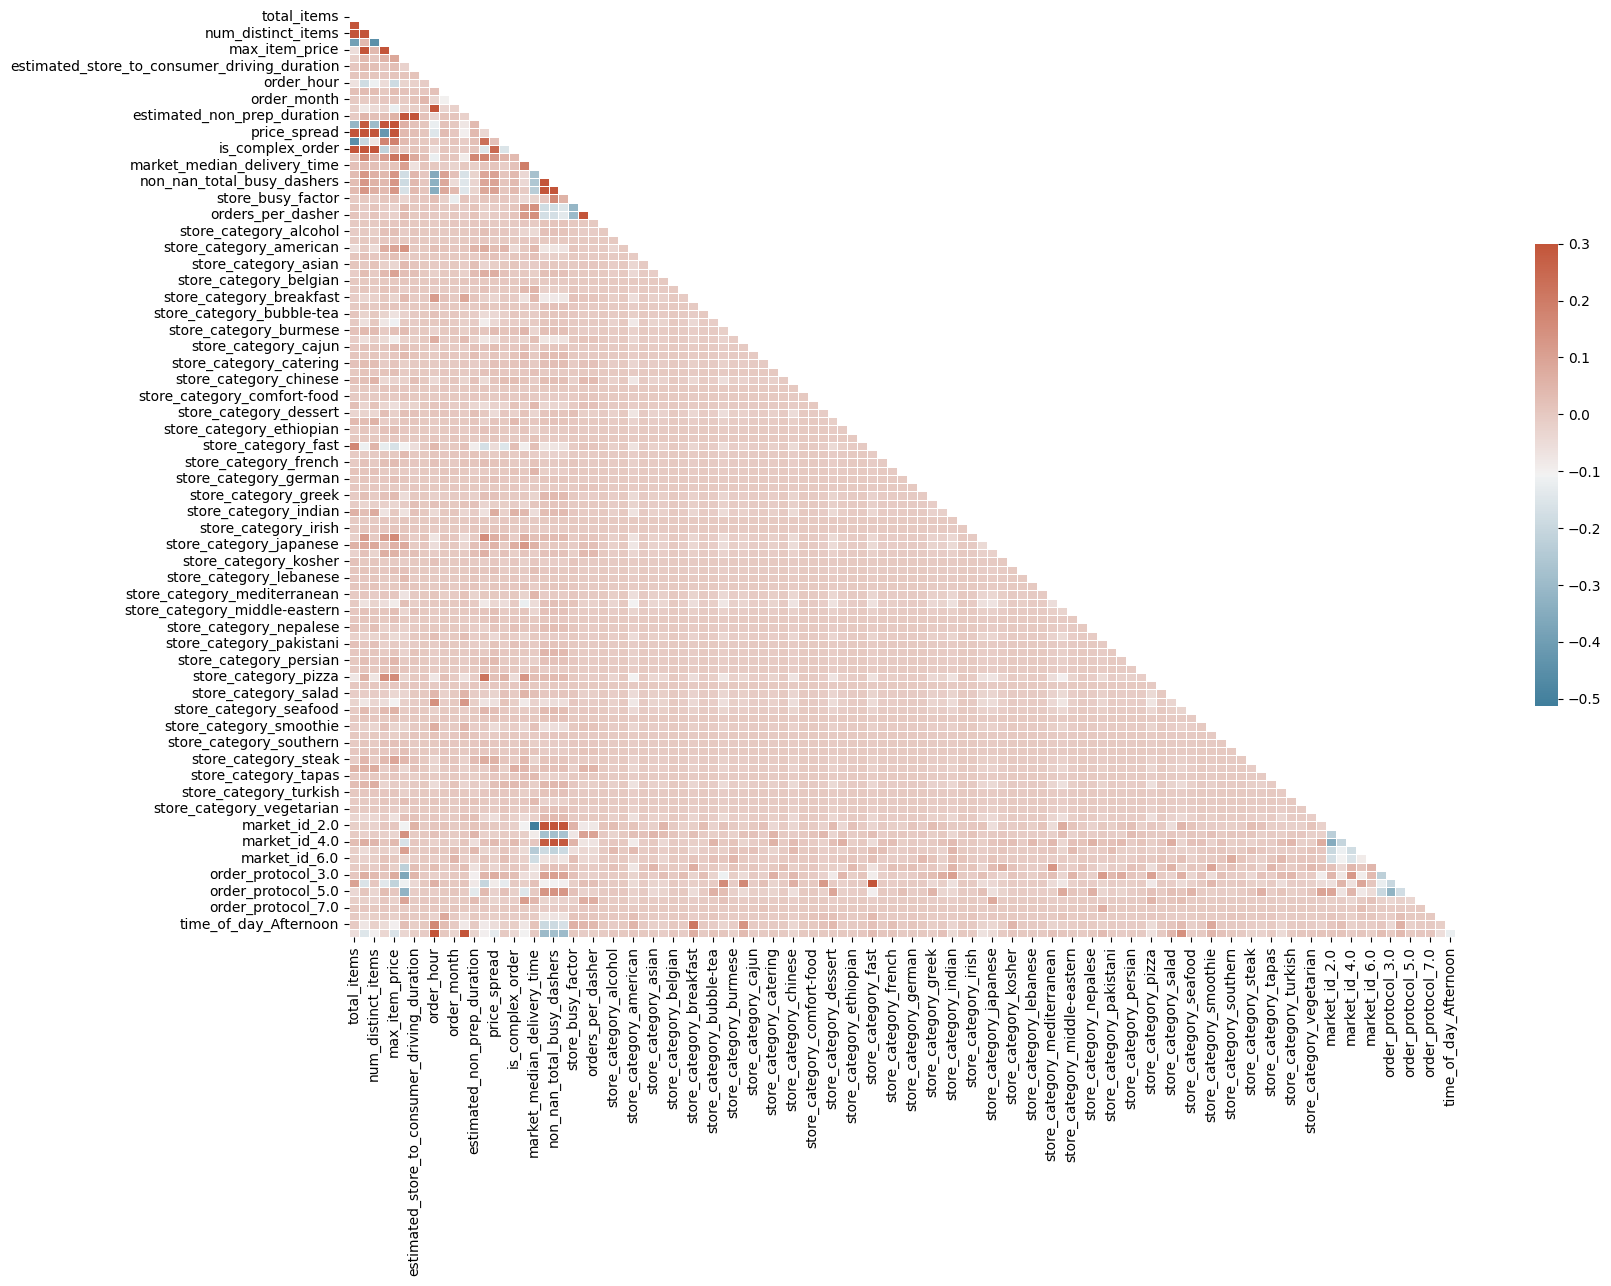

In [22]:
mask = np.triu(np.ones_like(corr_df, dtype=bool))
fig, ax = plt.subplots(figsize=(18, 12))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_df, mask=mask, cmap=cmap, vmax=0.3, linewidths=0.5, cbar_kws={"shrink": 0.5}, ax=ax)

plt.show()

#### Statsmodels regression

In [90]:
# Drop any rows with inf or nan values
X = train_df.drop(columns=["actual_total_delivery_duration"])

# Get corresponding y values
y = train_df["actual_total_delivery_duration"]

# Add constant and fit model
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     actual_total_delivery_duration   R-squared:                       0.003
Model:                                        OLS   Adj. R-squared:                  0.003
Method:                             Least Squares   F-statistic:                     5.907
Date:                            Sun, 09 Mar 2025   Prob (F-statistic):           5.85e-76
Time:                                    21:10:41   Log-Likelihood:            -2.2272e+06
No. Observations:                          197417   AIC:                         4.455e+06
Df Residuals:                              197308   BIC:                         4.456e+06
Df Model:                                     108                                         
Covariance Type:                        nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                         -200.2284     42.476     -4.714      0.000    -283.481    -116.976
total_items                                     10.4895     32.374      0.324      0.746     -52.962      73.941
subtotal                                         0.0306      0.059      0.519      0.603      -0.085       0.146
num_distinct_items                              30.1420     82.170      0.367      0.714    -130.910     191.194
min_item_price                                2.954e+11   4.43e+12      0.067      0.947   -8.39e+12    8.98e+12
max_item_price                               -2.954e+11   4.43e+12     -0.067      0.947   -8.98e+12    8.39e+12
estimated_order_place_duration                1.149e+09   1.72e+10      0.067      0.947   -3.26e+10    3.49e+10
estimated_store_to_consumer_driving_duration  1.149e+09   1.72e+10      0.067      0.947   -3.26e+10    3.49e+10
order_hour                                      46.7239     38.182      1.224      0.221     -28.111     121.559
order_dayofweek                                 68.8278     21.702      3.171      0.002      26.292     111.364
order_month                                   1812.9359     95.169     19.050      0.000    1626.406    1999.466
is_peak_hour                                   231.7409    184.853      1.254      0.210    -130.567     594.049
estimated_non_prep_duration                  -1.149e+09   1.72e+10     -0.067      0.947   -3.49e+10    3.26e+10
avg_item_price                                   0.0709      0.270      0.263      0.793      -0.458       0.600
price_spread                                  2.954e+11   4.43e+12      0.067      0.947   -8.39e+12    8.98e+12
unique_items_ratio                             -39.6328    359.164     -0.110      0.912    -743.586     664.321
is_complex_order                               125.9789    208.833      0.603      0.546    -283.328     535.286
store_median_delivery_time                       0.8243      0.108      7.629      0.000       0.613       1.036
market_median_delivery_time                     -1.2488      0.330     -3.786      0.000      -1.895      -0.602
non_nan_total_onshift_dashers                  -22.3823      5.515     -4.058      0.000     -33.193     -11.572
non_nan_total_busy_dashers                      15.3959      5.707      2.698      0.007       4.211      26.581
non_nan_total_outstanding_orders                 7.2304      3.532      2.047      0.041       0.308      14.152
store_busy_factor                              140.6177    144.815      0.971      0.332    -143.217     424.452
no_dashers_fl

In [91]:
vif = pd.DataFrame()
vif["Features"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

d:\projects\machine_learning_workspace\deliver_pred\.delivery_pred\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
d:\projects\machine_learning_workspace\deliver_pred\.delivery_pred\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Features,VIF
0,const,0.000000
1,total_items,3.971892
2,subtotal,5.742296
3,num_distinct_items,8.614274
4,min_item_price,inf
...,...,...
107,order_protocol_6.0,1.038548
108,order_protocol_7.0,1.008100
109,time_of_day_Morning,1.116684
110,time_of_day_Afternoon,6.091758


In [ ]:
vif.sort_values(by="VIF", ascending=False).reset_index(drop=True) # Significant multicollinearity among some features with huge VIF values

,Features,VIF
0,max_item_price,inf
1,min_item_price,inf
2,price_spread,inf
3,market_id_4.0,1.116438e+11
4,market_id_6.0,4.872575e+10
...,...,...
107,store_category_indonesian,1.002252e+00
108,store_category_belgian,1.002162e+00
109,store_category_chocolate,1.001226e+00
110,store_category_alcohol-plus-food,1.001132e+00


#### Penn State data experiments

In [24]:
# Create the data
data = {
    'Pt': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    'BP': [105, 115, 116, 117, 112, 121, 121, 110, 110, 114, 114, 115, 114, 106, 125, 114, 106, 113, 110, 122],
    'Age': [47, 49, 49, 50, 51, 48, 49, 47, 49, 48, 47, 49, 50, 45, 52, 46, 46, 46, 48, 56],
    'Weight': [85.4, 94.2, 95.3, 94.7, 89.4, 99.5, 99.8, 90.9, 89.2, 92.7, 94.4, 94.1, 91.6, 87.1, 101.3, 94.5, 87.0, 94.5, 90.5, 95.7],
    'BSA': [1.75, 2.10, 1.98, 2.01, 1.89, 2.25, 2.25, 1.90, 1.83, 2.07, 2.07, 1.98, 2.05, 1.92, 2.19, 1.98, 1.87, 1.90, 1.88, 2.09],
    'Dur': [5.1, 3.8, 8.2, 5.8, 7.0, 9.3, 2.5, 6.2, 7.1, 5.6, 5.3, 5.6, 10.2, 5.6, 10.0, 7.4, 3.6, 4.3, 9.0, 7.0],
    'Pulse': [63, 70, 72, 73, 72, 71, 69, 66, 69, 64, 74, 71, 68, 67, 76, 69, 62, 70, 71, 75],
    'Stress': [33, 14, 10, 99, 95, 10, 42, 8, 62, 35, 90, 21, 47, 80, 98, 95, 18, 12, 99, 99]
}

df = pd.DataFrame(data)
df

,Pt,BP,Age,Weight,BSA,Dur,Pulse,Stress
0,1,105,47,85.4,1.75,5.1,63,33
1,2,115,49,94.2,2.10,3.8,70,14
2,3,116,49,95.3,1.98,8.2,72,10
3,4,117,50,94.7,2.01,5.8,73,99
4,5,112,51,89.4,1.89,7.0,72,95
5,6,121,48,99.5,2.25,9.3,71,10
6,7,121,49,99.8,2.25,2.5,69,42
7,8,110,47,90.9,1.90,6.2,66,8
8,9,110,49,89.2,1.83,7.1,69,62
9,10,114,48,92.7,2.07,5.6,64,35


In [78]:
features = ["Age", "Weight", "BSA", "Dur", "Pulse", "Stress"]
X = df[features]
X = sm.add_constant(X)
[
    variance_inflation_factor(X.values, i)
    for i in range(X.shape[1])
]

[np.float64(788.3076923918795),
 np.float64(1.762806721767218),
 np.float64(8.41703502963307),
 np.float64(5.328751470118894),
 np.float64(1.2373094205198363),
 np.float64(4.413575165597283),
 np.float64(1.8348453242645864)]

In [88]:
# create multiple linear regression model using statsmodels for BP as dependent variable
X = df[["Age", "Weight", "BSA", "Dur", "Stress", "Pulse"]]
y = df["BP"]

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     BP   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     560.6
Date:                Sun, 09 Mar 2025   Prob (F-statistic):           6.40e-15
Time:                        21:07:25   Log-Likelihood:                -6.1033
No. Observations:                  20   AIC:                             26.21
Df Residuals:                      13   BIC:                             33.18
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.8705      2.557     -5.034      0.000     -18.394      -7.347
Age            0.7033      0.050     14.177      0.000       0.596       0.810
Weight         0.9699      0.063     15.369      0.000       0.834       1.106
BSA            3.7765      1.580      2.390      0.033       0.363       7.190
Dur            0.0684      0.048      1.412      0.182      -0.036       0.173
Stress         0.0056      0.003      1.633      0.126      -0.002       0.013
Pulse         -0.0845      0.052     -1.637      0.126      -0.196       0.027
==============================================================================
Omnibus:                        7.219   Durbin-Watson:                   2.249
Prob(Omnibus):                  0.027   Jarque-Bera (JB):                4.643
Skew:                          -1.050   Prob(JB):                       0.0981
Kurtosis:                       4.076   Cond. No.                     4.02e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.02e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [86]:
# create multiple linear regression model using statsmodels for BP as dependent variable
X = df[["Age", "Weight", "Dur", "Stress"]]
y = df["BP"]

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     BP   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     458.3
Date:                Sun, 09 Mar 2025   Prob (F-statistic):           1.76e-15
Time:                        21:02:51   Log-Likelihood:                -13.562
No. Observations:                  20   AIC:                             37.12
Df Residuals:                      15   BIC:                             42.10
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -15.8698      3.195     -4.967      0.000     -22.680      -9.059
Age            0.6837      0.061     11.173      0.000       0.553       0.814
Weight         1.0341      0.033     31.652      0.000       0.964       1.104
Dur            0.0399      0.064      0.619      0.545      -0.098       0.177
Stress         0.0022      0.004      0.576      0.573      -0.006       0.010
==============================================================================
Omnibus:                        0.318   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.853   Jarque-Bera (JB):                0.104
Skew:                          -0.162   Prob(JB):                        0.950
Kurtosis:                       2.860   Cond. No.                     3.10e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [87]:
features = ["Age", "Weight", "Dur", "Stress"]
for i in features:
    X = df[features].drop(columns=i)
    X = sm.add_constant(X)
    model = sm.OLS(df[i], X).fit()
    print(f"Feature: {i}")
    print(model.summary())
    print("R-Squared: ", model.rsquared)
    print("Variance Inflation Factor: ", (1/(1 - model.rsquared)))
    print("\n")

Feature: Age
                            OLS Regression Results                            
Dep. Variable:                    Age   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     2.497
Date:                Sun, 09 Mar 2025   Prob (F-statistic):             0.0968
Time:                        21:04:49   Log-Likelihood:                -42.355
No. Observations:                  20   AIC:                             92.71
Df Residuals:                      16   BIC:                             96.69
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.6017     11.233      2

In [56]:
df.drop(labels="Pt", axis=1).corr()

,BP,Age,Weight,BSA,Dur,Pulse,Stress
BP,1.000000,0.659093,0.950068,0.865879,0.292834,0.721413,0.163901
Age,0.659093,1.000000,0.407349,0.378455,0.343792,0.618764,0.368224
Weight,0.950068,0.407349,1.000000,0.875305,0.200650,0.659340,0.034355
BSA,0.865879,0.378455,0.875305,1.000000,0.130540,0.464819,0.018446
Dur,0.292834,0.343792,0.200650,0.130540,1.000000,0.401514,0.311640
Pulse,0.721413,0.618764,0.659340,0.464819,0.401514,1.000000,0.506310
Stress,0.163901,0.368224,0.034355,0.018446,0.311640,0.506310,1.000000


In [59]:
np.triu(np.ones(df.drop(labels="Pt", axis=1).corr().shape).astype(bool))

array([[ True,  True,  True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True,  True],
       [False, False,  True,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True],
       [False, False, False, False,  True,  True,  True],
       [False, False, False, False, False,  True,  True],
       [False, False, False, False, False, False,  True]])

In [60]:
df.drop(labels="Pt", axis=1).corr().mask(np.triu(np.ones(df.drop(labels="Pt", axis=1).corr().shape).astype(bool)))

,BP,Age,Weight,BSA,Dur,Pulse,Stress
BP,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,0.659093,NaN,NaN,NaN,NaN,NaN,NaN
Weight,0.950068,0.407349,NaN,NaN,NaN,NaN,NaN
BSA,0.865879,0.378455,0.875305,NaN,NaN,NaN,NaN
Dur,0.292834,0.343792,0.200650,0.130540,NaN,NaN,NaN
Pulse,0.721413,0.618764,0.659340,0.464819,0.401514,NaN,NaN
Stress,0.163901,0.368224,0.034355,0.018446,0.311640,0.50631,NaN


In [85]:
stacked = df.drop(labels=["Pt", "BP"], axis=1).corr().mask(np.triu(np.ones(df.drop(labels=["Pt", "BP"], axis=1).corr().shape).astype(bool))).stack()
stacked = stacked[stacked > 0.5].reset_index()
stacked.columns = ["feature1", "feature2", "correlation"]
stacked

,feature1,feature2,correlation
0,BSA,Weight,0.875305
1,Pulse,Age,0.618764
2,Pulse,Weight,0.659340
3,Stress,Pulse,0.506310


In [66]:
df.drop(labels="Pt", axis=1)

,BP,Age,Weight,BSA,Dur,Pulse,Stress
0,105,47,85.4,1.75,5.1,63,33
1,115,49,94.2,2.10,3.8,70,14
2,116,49,95.3,1.98,8.2,72,10
3,117,50,94.7,2.01,5.8,73,99
4,112,51,89.4,1.89,7.0,72,95
5,121,48,99.5,2.25,9.3,71,10
6,121,49,99.8,2.25,2.5,69,42
7,110,47,90.9,1.90,6.2,66,8
8,110,49,89.2,1.83,7.1,69,62
9,114,48,92.7,2.07,5.6,64,35


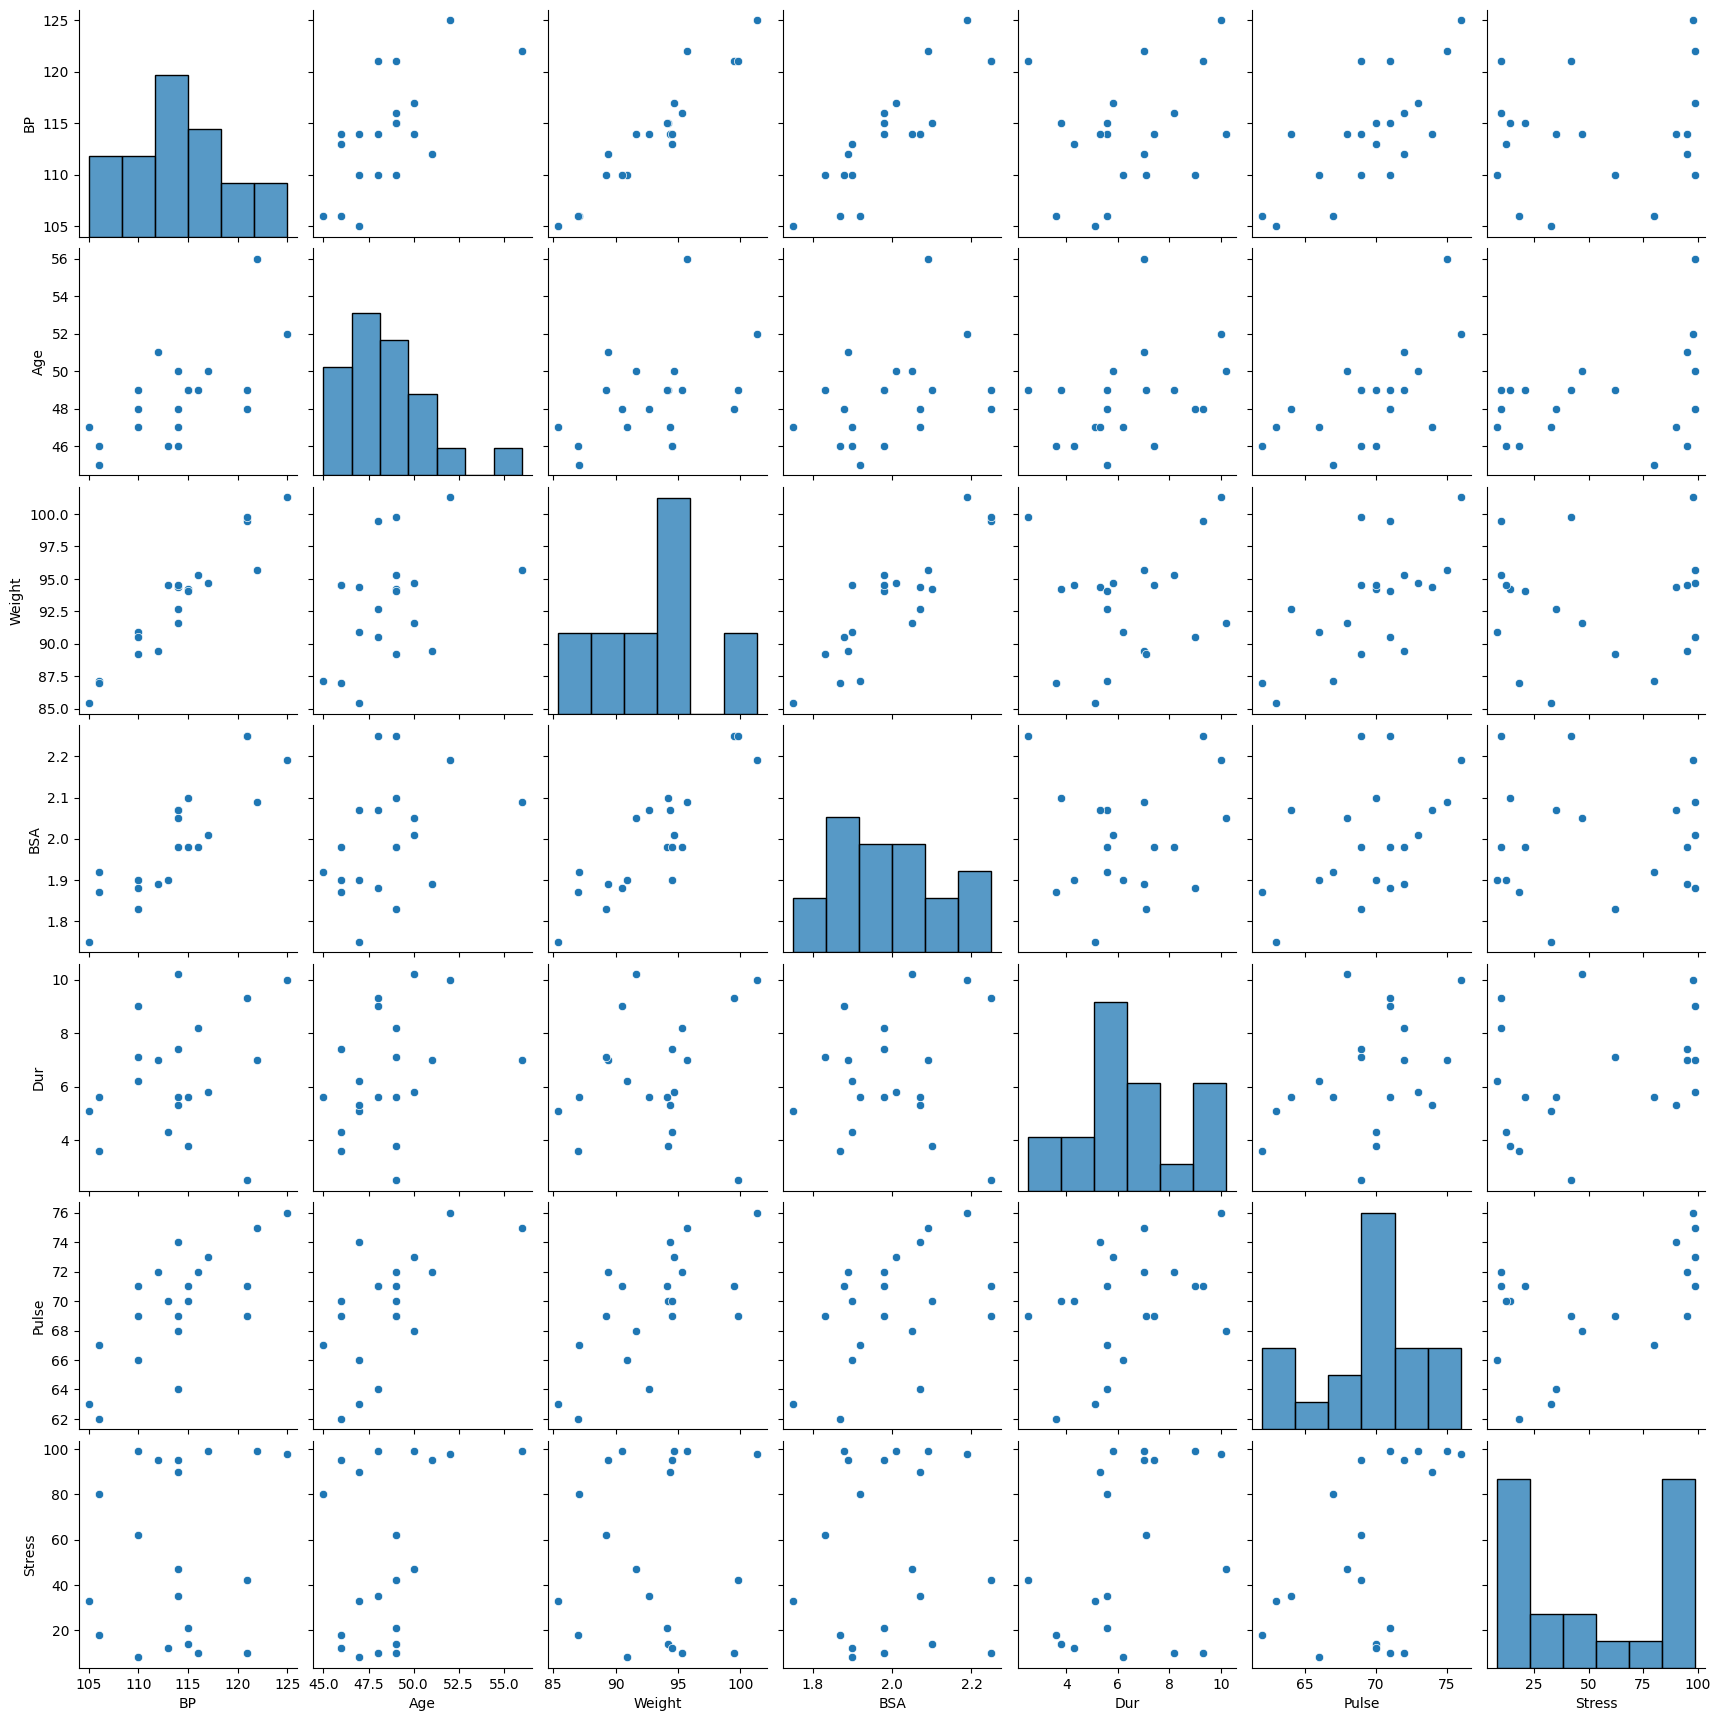

In [71]:
sns.pairplot(df.drop(labels="Pt", axis=1))

plt.show()

In [70]:
df.drop(labels="Pt", axis=1).corr().mask(np.triu(np.ones(df.drop(labels="Pt", axis=1).corr().shape).astype(bool)))

,BP,Age,Weight,BSA,Dur,Pulse,Stress
BP,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,0.659093,NaN,NaN,NaN,NaN,NaN,NaN
Weight,0.950068,0.407349,NaN,NaN,NaN,NaN,NaN
BSA,0.865879,0.378455,0.875305,NaN,NaN,NaN,NaN
Dur,0.292834,0.343792,0.200650,0.130540,NaN,NaN,NaN
Pulse,0.721413,0.618764,0.659340,0.464819,0.401514,NaN,NaN
Stress,0.163901,0.368224,0.034355,0.018446,0.311640,0.50631,NaN
